# Deep Convolutional GANs

This is a hands on experience building a Deep Convolutional Generative Adversarial Network (DCGAN). The following implementation is based on the [original paper](https://arxiv.org/pdf/1511.06434.pdf).

More details about this notebook as well as a quick introduction to GANs can be found in the accompanied article [here](https://sthalles.github.io).

In [1]:
%matplotlib inline

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import gzip
import zipfile
import utils

/wg/common/UTILITYSUITE/apps/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# set GPU node
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

## Getting the data

This implementation is built to support two datasets, [The Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) and the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. To choose between them, just assign one of the option variables to the **dataset_name** variable.

In [3]:
MNIST_DATASET = 'mnist'
SVHN_DATASET = 'svhn'

In [4]:
dataset_name = MNIST_DATASET

Since the goal here is to focus on GANs specifically, the details of downloading a preprocessing the dataset is factored in this `Dataset()` class from the `utils` package.

In [5]:
dataset = utils.Dataset(dataset_name, shuffle=True)
print("Dataset shape:", dataset.images().shape)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Dataset shape: (65000, 32, 32, 1)


Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB), for the SVHN and 32x32x1 for the MNIST images. Note that for the MNIST dataset we opted to pad the 28x28 black and white images with 0s so that they match the SVHNs spatial dimensions. These are the real images we'll pass to the discriminator and what the generator will eventually learn to fake.

This dataset object already does the required preprocessing, i.e. scale the images between -1 and 1 and it also has a `next_batch()` method for getting training mini-batches.

In [6]:
def display_images(dataset, figsize=(6,6), denomalize=False):
    fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=figsize,)
    for ii, ax in enumerate(axes.flatten()):
        img = dataset[ii,:,:,:]
        if dataset_name == SVHN_DATASET:
            if denomalize:
                img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8) # Scale back to 0-255
            ax.imshow(img, aspect='equal')
        elif dataset_name == MNIST_DATASET:
            if denomalize:
                img = (img - img.min()) / (img.max() - img.min()) # Scale back to 0-1
            ax.imshow(img.reshape(32,32), cmap='gray')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    plt.subplots_adjust(wspace=0, hspace=0)

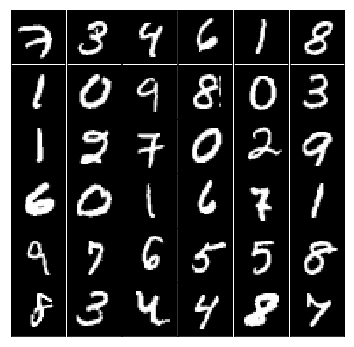

In [7]:
display_images(dataset.images())

## Wrapper functions

These are Tensorflow's wrapper function for the most important routines we will be using in this implementation. According to the paper, the variables are initialized with values from a normal distribution with *mean* of 0 and *standard deviation* of 0.02. Both convolutions and transpose convolutions have 'same' padding and they both use strides of 2 either to reduce in half or to double increase the inputs’ spatial dimensions.

In [8]:
def dense(x, out_units):
    return tf.layers.dense(x, out_units, activation=None,
                          kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))

def conv2d(x, output_space):
    return tf.layers.conv2d(x, output_space, kernel_size=5, strides=2, padding="same", activation=None,
                           kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))

def lrelu(x, alpha=0.2):
     # non-linear activation function
    return tf.maximum(alpha * x, x)

def batch_norm(x, training, epsilon=1e-5, momentum=0.9):
     return tf.layers.batch_normalization(x, training=training, epsilon=epsilon, momentum=momentum)
    
def transpose_conv2d(x, output_space):
    return tf.layers.conv2d_transpose(x, output_space, 5, strides=2, padding='same',
                                     kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))

## Network Inputs

Here, just creating some placeholders to feed the Generator and Discriminator nets.

In [9]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## Generator

The network has 4 convolutional layers, all of them followed by batch normalization (except for the output layer) and rectified linear unit (RELU) activations. It will take as input a random vector z (drawn from a normal distribution), which will be reshaped in a 4D tensor and start a series of upsampling layers by applying transpose convolutional operations with strides of 2.

All the transpose convolutions use kernel filters of size 5x5 and the kernel depth goes from 512 all the way down to 3 - representing the RGB color channels. The final layer then outputs a 32x32x3 tensor that will be squashed between -1 and 1 through the [Hyperbolic Tangent](https://reference.wolfram.com/language/ref/Tanh.html) function.

In [10]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    """
    Generator network
    :param z: input random vector z
    :param output_dim: output dimension of the network
    :param reuse: Indicates whether or not the existing model variables should be used or recreated
    :param alpha: scalar for lrelu activation function
    :param training: Boolean for controlling the batch normalization statistics
    :return: model's output
    """
    with tf.variable_scope('generator', reuse=reuse):
        fc1 = dense(z, 4*4*512)
        
        # Reshape it to start the convolutional stack
        fc1 = tf.reshape(fc1, (-1, 4, 4, 512))
        fc1 = batch_norm(fc1, training=training)
        fc1 = tf.nn.relu(fc1)
        
        t_conv1 = transpose_conv2d(fc1, 256)
        t_conv1 = batch_norm(t_conv1, training=training)
        t_conv1 = tf.nn.relu(t_conv1)
        
        t_conv2 = transpose_conv2d(t_conv1, 128)
        t_conv2 = batch_norm(t_conv2, training=training)
        t_conv2 = tf.nn.relu(t_conv2)
        
        logits = transpose_conv2d(t_conv2, output_dim)
        
        out = tf.tanh(logits)
        return out

## Discriminator

The discriminator is also a 4 layer convolutional neural network followed by batch normalization (except its input layer) and leaky RELU activations. The network receives a 32x32x3 image tensor and performs regular convolutional operations with ‘same’ padding and strides of 2 - which basically double the size of the filters at each layer. Finally, the discriminator needs to output probabilities. For that, we use the Logistic [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) activation function for the top layer.

In [11]:
def discriminator(x, reuse=False, alpha=0.2, training=True):
    """
    Discriminator network
    :param x: input for network
    :param reuse: Indicates whether or not the existing model variables should be used or recreated
    :param alpha: scalar for lrelu activation function
    :param training: Boolean for controlling the batch normalization statistics
    :return: A tuple of (sigmoid probabilities, logits)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x?
        conv1 = conv2d(x, 64)
        conv1 = lrelu(conv1, alpha)
        
        conv2 = conv2d(conv1, 128)
        conv2 = batch_norm(conv2, training=training)
        conv2 = lrelu(conv2, alpha)
        
        conv3 = conv2d(conv2, 256)
        conv3 = batch_norm(conv3, training=training)
        conv3 = lrelu(conv3, alpha)

        # Flatten it
        flat = tf.reshape(conv3, (-1, 4*4*256))
        logits = dense(flat, 1)

        out = tf.sigmoid(logits)
        return out, logits

## Model Loss

We know that the discriminator receives images from both, the training set and from the generator. We want the discriminator to be able to distinguish between real and fake images. Since we want the discriminator to output probabilities close to 1 for real images and near 0 for fake images, we need two partial losses for the discriminator. The total loss for the discriminator is then, the sum of the two losses - one for maximizing the probabilities for the real images and another for minimizing the probability of fake images.

In [12]:
def model_loss(input_real, input_z, output_dim, alpha=0.2, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: random vector z
    :param out_channel_dim: The number of channels in the output image
    :param smooth: label smothing scalar 
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    tf.summary.scalar('mean_discriminator_output_prob_real', tf.reduce_mean(d_model_real))
        
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    tf.summary.scalar('mean_discriminator_output_prob_fake', tf.reduce_mean(d_model_fake))
    
    # for the real image from the training set, we want them to be classified as positives,  
    # so we want their labels to be all ones. 
    # notice here we use label smoothing for helping the discriminator to generalize better. 
    # Label smoothing works by avoiding the classifier to make extreme predictions when extrapolating.
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    
    # for the fake images produced by the generator, we want the discriminator to clissify them as false images,
    # so we set their labels to be all zeros.
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    # since the generator wants the discriminator to output 1s for its images, it uses the discriminator logits for the
    # fake images and assign labels of 1s to them.
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    tf.summary.scalar('generator_loss', g_loss)
    
    d_loss = d_loss_real + d_loss_fake
    tf.summary.scalar('discriminator_loss', d_loss)
    
    return d_loss, g_loss, g_model, input_real

## Optimizers

Because the generator and the discriminator networks train simultaneity, GANs require two optimizers to run at the same time. Each one for minimizing the discriminator and generator’s loss functions respectively.

In [13]:
def model_optimizers(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias variables for each network
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Because the batch norm layers are not part of the graph we inforce these operation to run before the 
    # optimizers so the batch normalization layers can update their population statistics.
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

Set up the Hyperparameters.

In [14]:
real_size = dataset.images().shape[1:]
z_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 10
alpha = 0.2
beta1 = 0.5

Get the placeholders from the helper functions and setup other variables.

In [15]:
tf.reset_default_graph()

input_real, input_z = model_inputs(real_size, z_size)
d_loss, g_loss, g_fake, d_real = model_loss(input_real, input_z, real_size[2], alpha=0.2)
d_opt, g_opt = model_optimizers(d_loss, g_loss, learning_rate, 0.5)

# image summary
tf.summary.image("real_images", d_real)
tf.summary.image("fake_images", g_fake)

#
sample_z = np.random.uniform(-1, 1, size=(36, z_size))

image_counter = 0

# change this variable if you want to produce video with the generator's samples during training
save_video = False

if save_video:
    folder = "./video"
    if not os.path.isdir(folder):
        os.makedirs(folder)

Dataset shuffled successfully.
Epoch 1/10... Discriminator Loss: 1.3771... Generator Loss: 0.0412
Epoch 1/10... Discriminator Loss: 2.8854... Generator Loss: 1.3055
Epoch 1/10... Discriminator Loss: 2.2902... Generator Loss: 2.1260
Epoch 1/10... Discriminator Loss: 1.7039... Generator Loss: 2.6998
Epoch 1/10... Discriminator Loss: 1.2698... Generator Loss: 3.8488
Epoch 1/10... Discriminator Loss: 0.9880... Generator Loss: 2.0821
Epoch 1/10... Discriminator Loss: 0.8083... Generator Loss: 2.9471
Epoch 1/10... Discriminator Loss: 0.9602... Generator Loss: 2.4712
Epoch 1/10... Discriminator Loss: 1.4793... Generator Loss: 0.9769
Epoch 1/10... Discriminator Loss: 1.0894... Generator Loss: 1.4458
Epoch 1/10... Discriminator Loss: 1.2039... Generator Loss: 0.9170
Epoch 1/10... Discriminator Loss: 1.1346... Generator Loss: 2.0191
Epoch 1/10... Discriminator Loss: 1.4982... Generator Loss: 2.8529
Epoch 1/10... Discriminator Loss: 1.4076... Generator Loss: 1.0283
Epoch 1/10... Discriminator Los

Epoch 3/10... Discriminator Loss: 1.1841... Generator Loss: 0.7452
Epoch 3/10... Discriminator Loss: 1.8251... Generator Loss: 0.3517
Epoch 3/10... Discriminator Loss: 1.2144... Generator Loss: 0.8581
Epoch 3/10... Discriminator Loss: 1.2541... Generator Loss: 0.7428
Epoch 3/10... Discriminator Loss: 1.1925... Generator Loss: 0.9838
Epoch 3/10... Discriminator Loss: 1.1815... Generator Loss: 0.8535
Epoch 3/10... Discriminator Loss: 1.2855... Generator Loss: 0.8687
Epoch 3/10... Discriminator Loss: 1.2342... Generator Loss: 0.9526
Epoch 3/10... Discriminator Loss: 1.2127... Generator Loss: 0.5731
Epoch 3/10... Discriminator Loss: 1.1761... Generator Loss: 0.9709
Epoch 3/10... Discriminator Loss: 1.4441... Generator Loss: 0.8116
Epoch 3/10... Discriminator Loss: 1.2320... Generator Loss: 0.8787
Epoch 3/10... Discriminator Loss: 1.2589... Generator Loss: 0.8484
Epoch 3/10... Discriminator Loss: 1.2077... Generator Loss: 0.8381
Epoch 3/10... Discriminator Loss: 1.1769... Generator Loss: 0.

/wg/common/UTILITYSUITE/apps/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch 4/10... Discriminator Loss: 1.1821... Generator Loss: 0.7408
Epoch 4/10... Discriminator Loss: 1.1984... Generator Loss: 0.9543
Epoch 4/10... Discriminator Loss: 1.3687... Generator Loss: 0.7105
Dataset shuffled successfully.
Epoch 5/10... Discriminator Loss: 1.2895... Generator Loss: 0.6831
Epoch 5/10... Discriminator Loss: 1.1767... Generator Loss: 0.7535
Epoch 5/10... Discriminator Loss: 1.3716... Generator Loss: 0.4587
Epoch 5/10... Discriminator Loss: 1.1762... Generator Loss: 0.9167
Epoch 5/10... Discriminator Loss: 1.1768... Generator Loss: 0.6906
Epoch 5/10... Discriminator Loss: 1.5043... Generator Loss: 0.6130
Epoch 5/10... Discriminator Loss: 1.2922... Generator Loss: 0.7895
Epoch 5/10... Discriminator Loss: 1.1606... Generator Loss: 0.7797
Epoch 5/10... Discriminator Loss: 1.2091... Generator Loss: 0.7982
Epoch 5/10... Discriminator Loss: 1.3031... Generator Loss: 1.4550
Epoch 5/10... Discriminator Loss: 1.2171... Generator Loss: 0.6357
Epoch 5/10... Discriminator Los

Epoch 7/10... Discriminator Loss: 1.1648... Generator Loss: 0.4958
Epoch 7/10... Discriminator Loss: 1.3215... Generator Loss: 0.7242
Epoch 7/10... Discriminator Loss: 1.3283... Generator Loss: 0.9535
Epoch 7/10... Discriminator Loss: 1.2450... Generator Loss: 0.8411
Epoch 7/10... Discriminator Loss: 1.2173... Generator Loss: 1.0843
Epoch 7/10... Discriminator Loss: 1.3348... Generator Loss: 0.4780
Epoch 7/10... Discriminator Loss: 1.2101... Generator Loss: 0.8368
Epoch 7/10... Discriminator Loss: 1.2397... Generator Loss: 1.2268
Epoch 7/10... Discriminator Loss: 1.5056... Generator Loss: 1.5647
Epoch 7/10... Discriminator Loss: 1.2282... Generator Loss: 0.8133
Epoch 7/10... Discriminator Loss: 1.2862... Generator Loss: 1.4799
Epoch 7/10... Discriminator Loss: 1.2207... Generator Loss: 0.9707
Epoch 7/10... Discriminator Loss: 1.2910... Generator Loss: 1.6766
Epoch 7/10... Discriminator Loss: 1.2660... Generator Loss: 1.1956
Epoch 7/10... Discriminator Loss: 1.2624... Generator Loss: 0.

Epoch 9/10... Discriminator Loss: 1.1565... Generator Loss: 0.6412
Epoch 9/10... Discriminator Loss: 1.1219... Generator Loss: 0.9671
Epoch 9/10... Discriminator Loss: 1.1264... Generator Loss: 0.5569
Epoch 9/10... Discriminator Loss: 1.0541... Generator Loss: 0.8749
Epoch 9/10... Discriminator Loss: 1.2248... Generator Loss: 0.5722
Epoch 9/10... Discriminator Loss: 1.2037... Generator Loss: 0.9879
Epoch 9/10... Discriminator Loss: 1.2337... Generator Loss: 1.1886
Epoch 9/10... Discriminator Loss: 1.2221... Generator Loss: 0.7579
Epoch 9/10... Discriminator Loss: 1.1035... Generator Loss: 0.6025
Epoch 9/10... Discriminator Loss: 1.1107... Generator Loss: 0.7916
Epoch 9/10... Discriminator Loss: 1.2223... Generator Loss: 1.1537
Epoch 9/10... Discriminator Loss: 1.1740... Generator Loss: 0.7740
Epoch 9/10... Discriminator Loss: 1.1836... Generator Loss: 1.0026
Epoch 9/10... Discriminator Loss: 1.2929... Generator Loss: 0.7031
Dataset shuffled successfully.
Epoch 10/10... Discriminator Lo

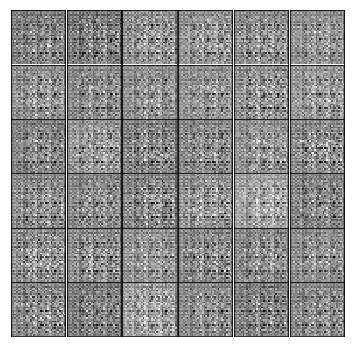

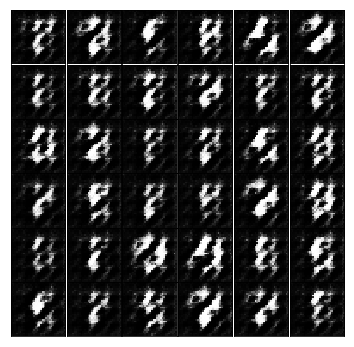

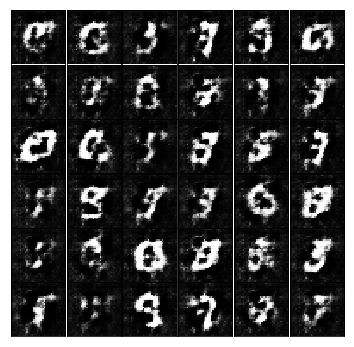

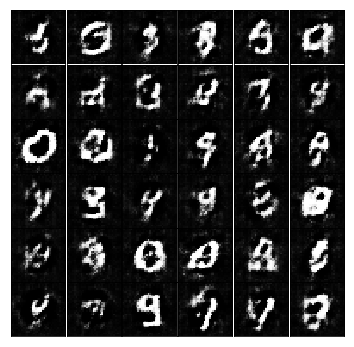

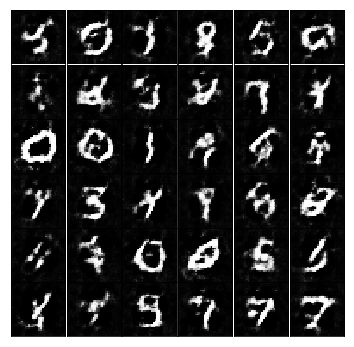

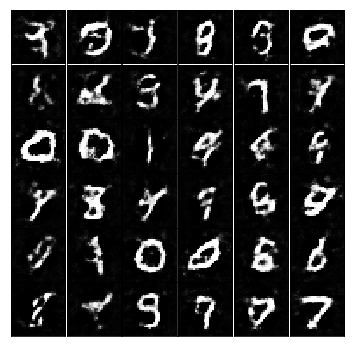

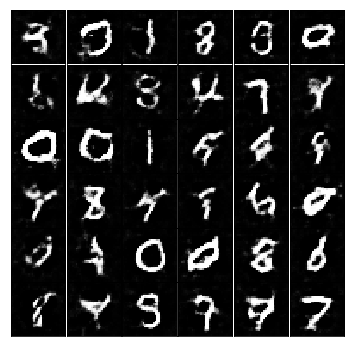

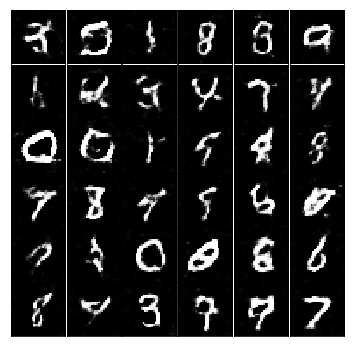

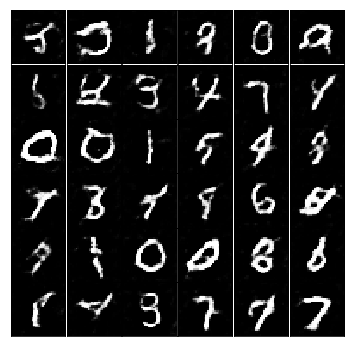

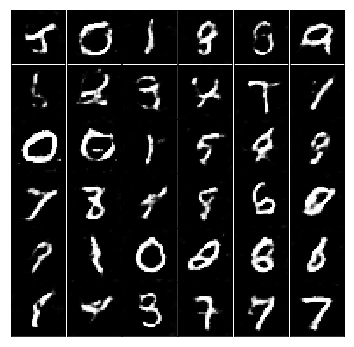

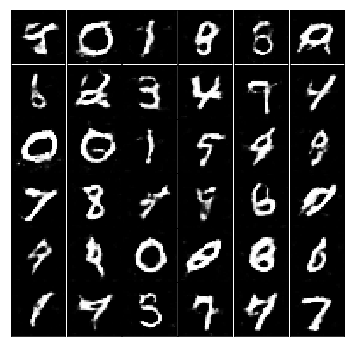

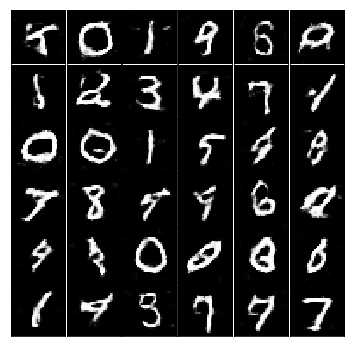

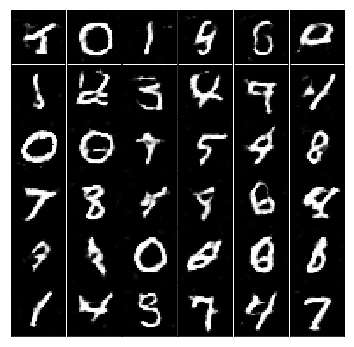

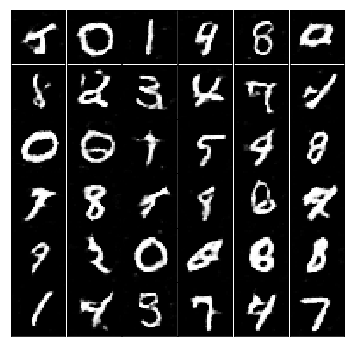

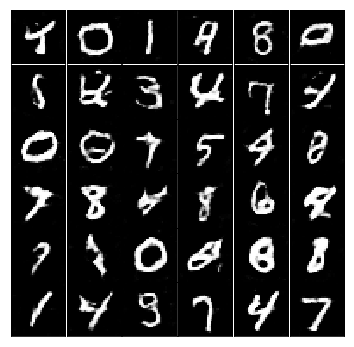

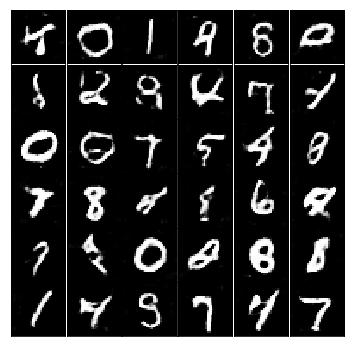

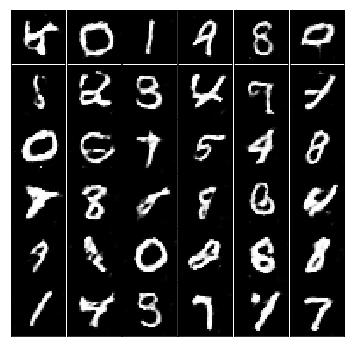

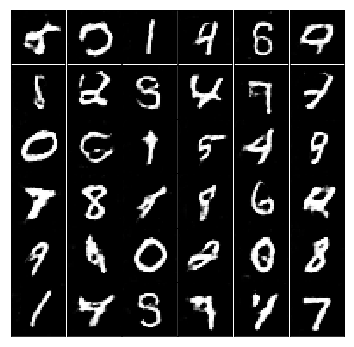

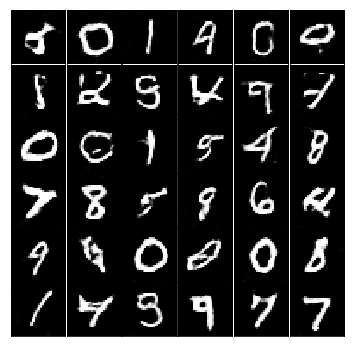

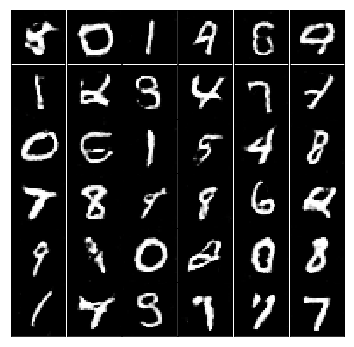

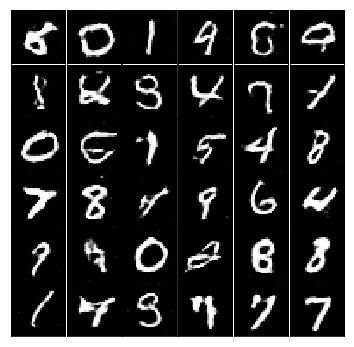

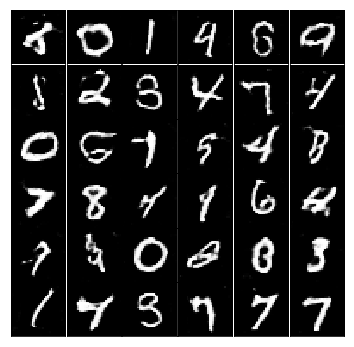

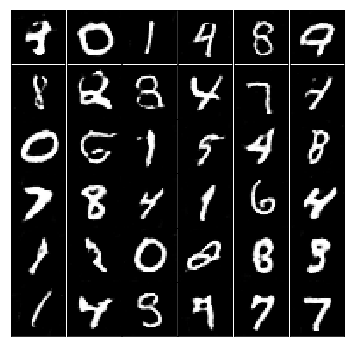

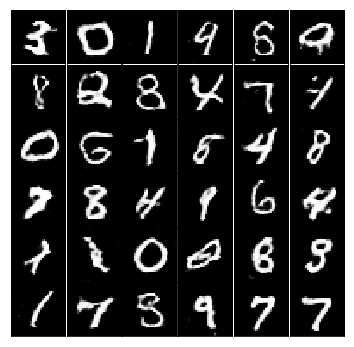

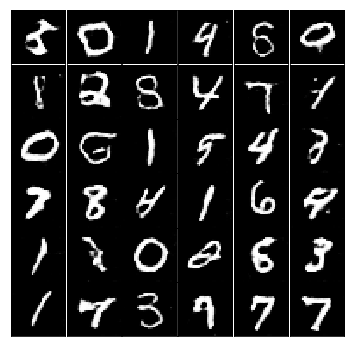

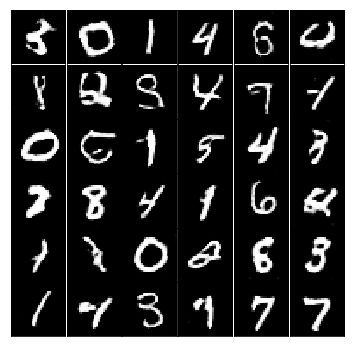

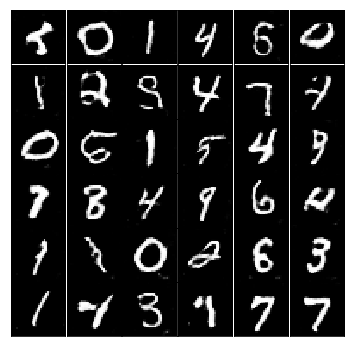

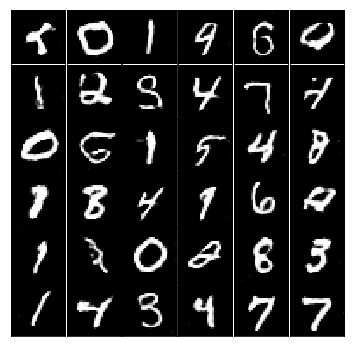

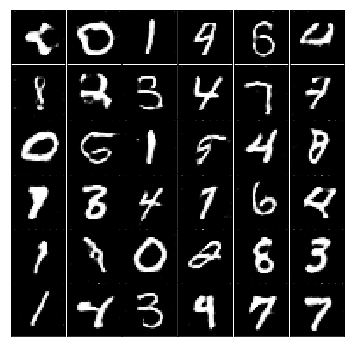

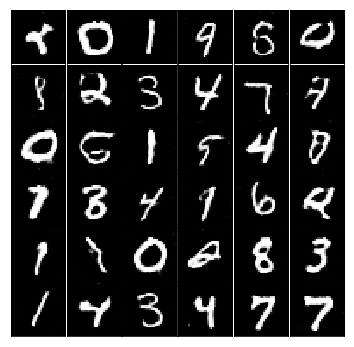

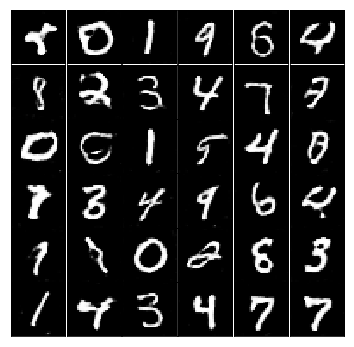

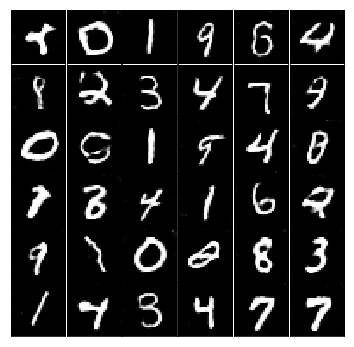

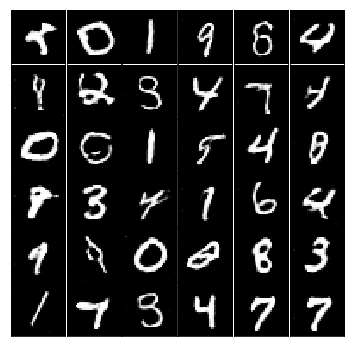

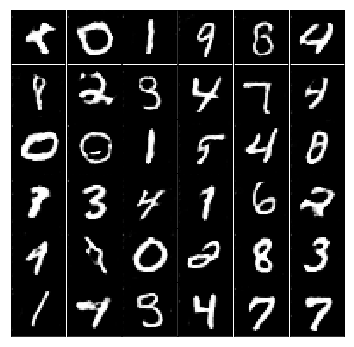

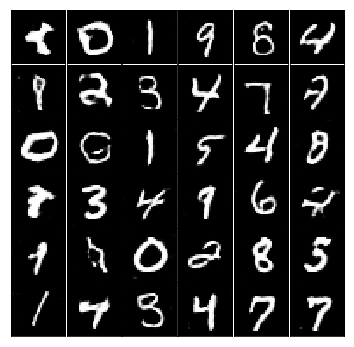

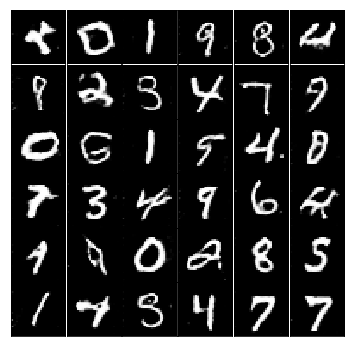

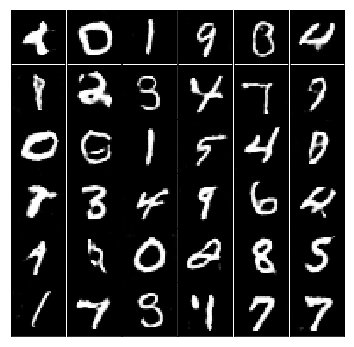

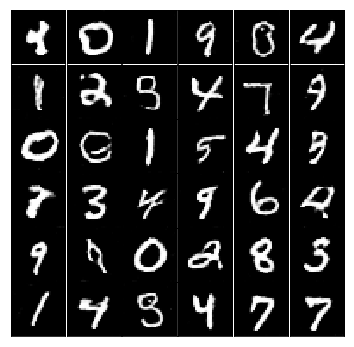

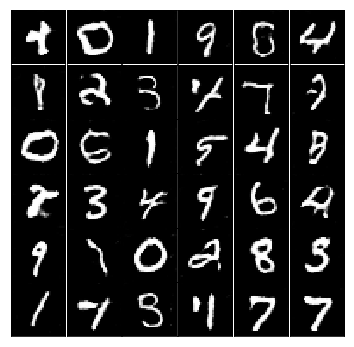

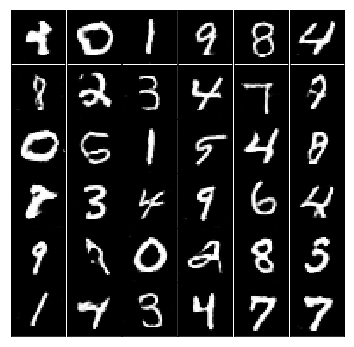

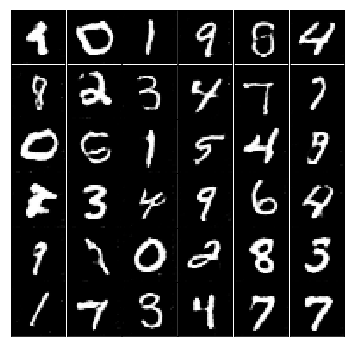

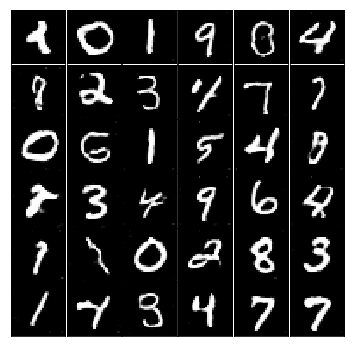

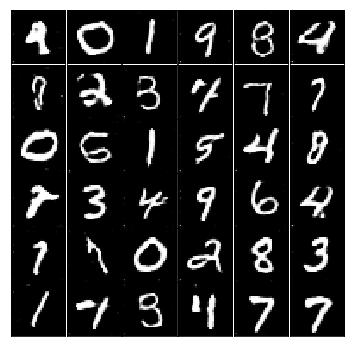

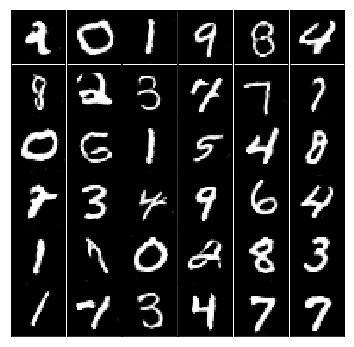

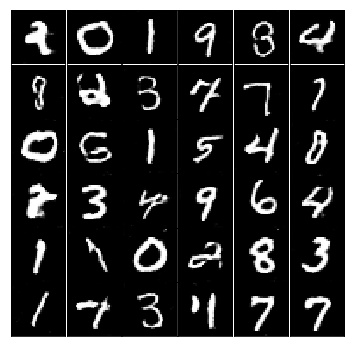

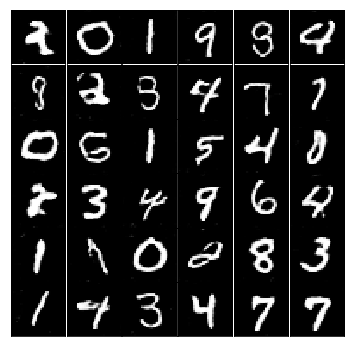

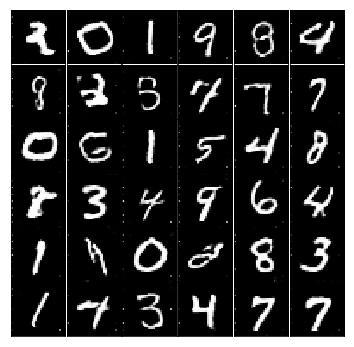

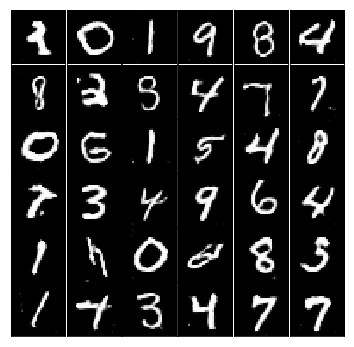

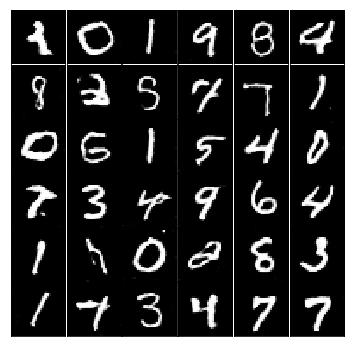

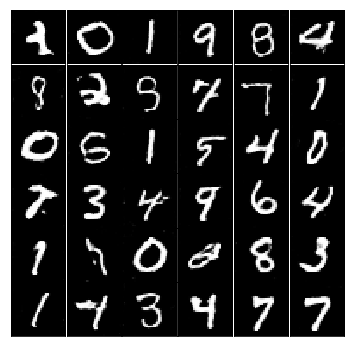

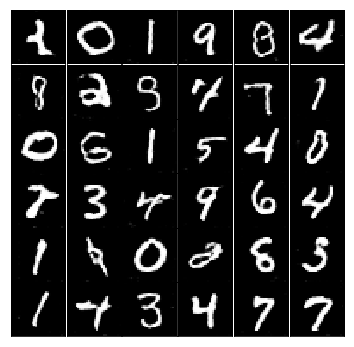

In [16]:
import time

steps = 0
with tf.Session() as sess:
    # Merge all the summaries and write them out
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter('./logdir/' + str(time.time()), sess.graph)
    
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for x in dataset.next_batch(batch_size):
            # Sample random noise for G
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

            # Update the discriminator network
            _, summary, train_loss_d = sess.run([d_opt, merged, d_loss], feed_dict={input_real: x, input_z: batch_z})
            
            # Update the generator twice two avoid the rapid convergence of the discriminator
            _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: x})
            _, train_loss_g = sess.run([g_opt, g_loss], feed_dict={input_z: batch_z, input_real: x})

            if steps % 10 == 0:
                train_writer.add_summary(summary, steps)

                print("Epoch {}/{}...".format(e+1, epochs),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))
            
            if steps % 100 == 0:
                # At the end of each batch, sample some data from the generator, display and save it.
                # Notice when the generator creates the samples to displaied, we set training to False. 
                # That is important for signalling the batch normalization layers to use the population statistics rather 
                # than the batch statistics
                gen_samples = sess.run(generator(input_z, real_size[2], reuse=True, training=False),
                                       feed_dict={input_z: sample_z})
  
                display_images(gen_samples, denomalize=True)

                # save the samples to disk
                if save_video:
                    plt.savefig(folder + "/file%02d.png" % image_counter)
                    image_counter += 1
                    plt.show()
                
            steps += 1

In [17]:
if save_video:
    utils.generate_video(dataset_name, folder)